# Analyze `dmsa-phenotype` predictions

## Import `Python` modules

In [5]:
import os
import sys
import glob
import pandas as pd
from collections import defaultdict
import lzma

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Assign each serum sample to a cohort

In [6]:
cohort_dict = {
    'children' : [
        3944,
        2389,
        2323,
        2388,
        3973,
        4299,
        4584,
        2367,
    ],
    'teenagers' : [
        2350,
        2365,
        2382,
        3866,
        2380,
        3856, # outlier
        3857,
        3862,
    ],
    'adults' : [
        '33C',
        '34C',
        '197C',
        '199C',
        '215C',
        '210C',
        '74C',
        '68C',
        '150C',
        '18C',
    ],
    'elderly' : [
        'AUSAB-13'
    ],
    'infant' : [
        2462
    ]
}
serum_to_cohort_dict = defaultdict(list)
for (cohort, sera) in cohort_dict.items():
    for serum in sera:
        serum_to_cohort_dict['cohort'].append(cohort)
        serum_to_cohort_dict['serum'].append(str(serum))
serum_to_cohort_df = pd.DataFrame(serum_to_cohort_dict)

## Analyze predicted escape scores

For each serum sample, read in predicted escape scores for each virus on the Nextstrain tree. Also read in metadata for each virus (e.g., sampling date).

In [7]:
# Read in escape scores
yr = 12
resultsdir = f'builds/flu_seasonal_h3n2_{yr}y/ha/dmsa-phenotype/all-sera/'
fs = glob.glob(os.path.join(resultsdir, '*.csv'))
dfs = []
for f in fs:
    serum = os.path.basename(f).replace('_avg.csv_variant_escape_prediction.csv', '')
    df = pd.read_csv(f)
    df['serum'] = serum
    df.rename(columns={'pred_phenotype':'escape_score'}, inplace=True)
    dfs.append(df)
escape_df = pd.concat(dfs)

# Drop escape scores for internal nodes
escape_df = escape_df[~escape_df['strain'].str.contains('NODE')]

# Add metadata
metadata_df = pd.read_csv(f'profiles/dmsa-phenotype/sequences/{yr}y_metadata.tsv.xz', sep=',')
metadata_df['date'] = pd.to_datetime(metadata_df['date'], errors='coerce')
escape_df = escape_df.merge(metadata_df, on='strain')
escape_df = escape_df.merge(serum_to_cohort_df, on='serum', how='left')

# Add a column giving time in years since a reference date
escape_df['time'] = (escape_df['date'] - pd.to_datetime('2020-01-01')).dt.days / 365

Identify sites that have strong mutational effects in the DMS data

In [8]:
sera_to_analyze = cohort_dict['children'] + cohort_dict['teenagers'] + cohort_dict['adults']
dfs = []
for serum in sera_to_analyze:
    f = f'profiles/dmsa-phenotype/antibody_escape/filtered_data/{serum}_avg.csv'
    df = pd.read_csv(f)
    df['serum'] = serum
    dfs.append(df)
mut_effects_df = pd.concat(dfs)
cutoff = 0.25
important_sites = mut_effects_df[
    (mut_effects_df['escape_median'] > cutoff) |
    (mut_effects_df['escape_median'] < -cutoff)
]['site'].unique()
len(important_sites)

291

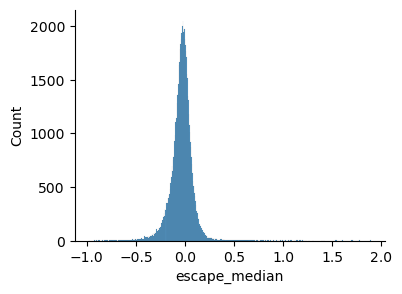

In [9]:
plt.figure(figsize=[4,3])
sns.histplot(x='escape_median', data=mut_effects_df)
sns.despine()
plt.show()

What are the disallowed mutations that are popping up?

In [10]:
# Get a list of all disallowed subs
disallowed_subs = []
sub_col = 'disallowed_aa_substitutions'
data = escape_df[escape_df[sub_col].notnull()]
for subs in data[sub_col]:
    disallowed_subs += subs.split(' ')

# Make a dataframe with counts
counts_dict = defaultdict(list)
(subs, counts) = np.unique(disallowed_subs, return_counts = True)
for (sub, count) in zip(subs, counts):
    counts_dict['sub'].append(sub)
    counts_dict['count'].append(count)
counts_df = pd.DataFrame(counts_dict)
counts_df['site'] = counts_df['sub'].apply(lambda x: int(x[1:-1]))
counts_df['important_site'] = counts_df['site'].apply(lambda x: x in important_sites)
counts_df.sort_values('count', ascending=False).head(n=20)

,sub,count,site,important_site
9,D104G,1989,104,True
27,F79V,1248,79,False
62,K2E,858,2,False
74,L194P,585,194,True
122,S205F,507,205,False
87,M168V,429,168,True
38,I140R,273,140,True
73,L157I,273,157,True
107,P221L,234,221,True
10,D104N,156,104,True


In [11]:
mut_effects_df[
    ((mut_effects_df['escape_median'] > cutoff) |
    (mut_effects_df['escape_median'] < -cutoff)) &
    (mut_effects_df['site'] == 104)
]

,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_min_magnitude,escape_std,n_models,times_seen,frac_models,serum
647,1,104,D,Y,D104Y,-0.2861,-0.2861,-0.123,0.2307,2,3.5,1.0,2323


<Axes: xlabel='n_disallowed_aa_substitutions', ylabel='Count'>

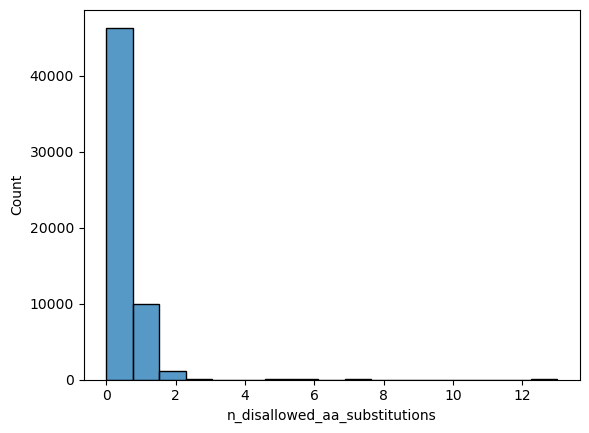

In [12]:
sns.histplot(x='n_disallowed_aa_substitutions', data=escape_df)

In [13]:
print(len(escape_df))
print(sum(escape_df['disallowed_aa_substitutions'].notnull()))

57642
11303


## Analyze distributions of escape scores

Plot a histogram of all escape scores across all viruses and serum samples

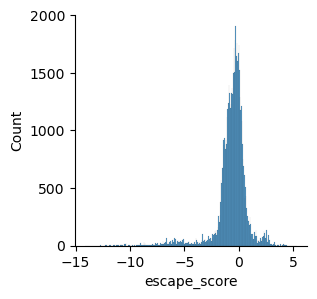

In [14]:
plt.figure(figsize=[3,3])
sns.histplot(x='escape_score', data=escape_df)
sns.despine()
plt.show()

For each strain, plot the average escape score across all serum samples in a given cohort.

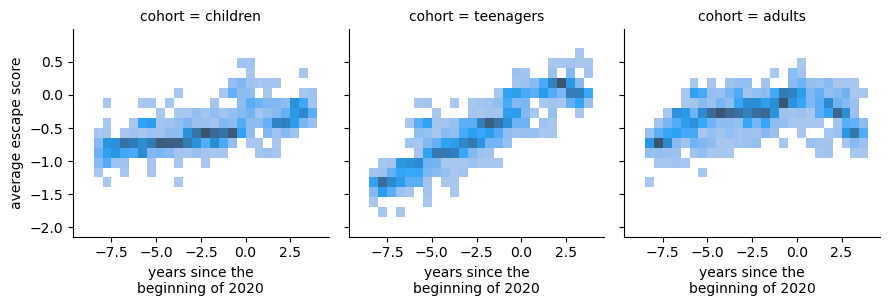

In [15]:
data = escape_df.groupby(['strain', 'cohort'])[['escape_score', 'time']].mean().reset_index()
data = data.merge(metadata_df, on='strain')
cohort_order = [
    #'infant',
    'children', 'teenagers', 'adults',
    # 'elderly'
]
binsx = np.arange(-9, 4.5, 0.5)
binsy = np.arange(-2, 1, 0.15)
g = sns.FacetGrid(data, col="cohort", col_order=cohort_order)
g.map(
    sns.histplot, "time", "escape_score",
    bins=(binsx, binsy)
)
g.set(ylabel='average escape score', xlabel='years since the\nbeginning of 2020')
plt.show()

Plot data for all serum samples in a given cohort

infant


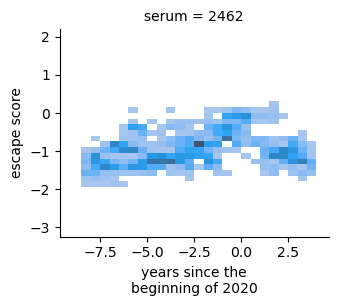

children


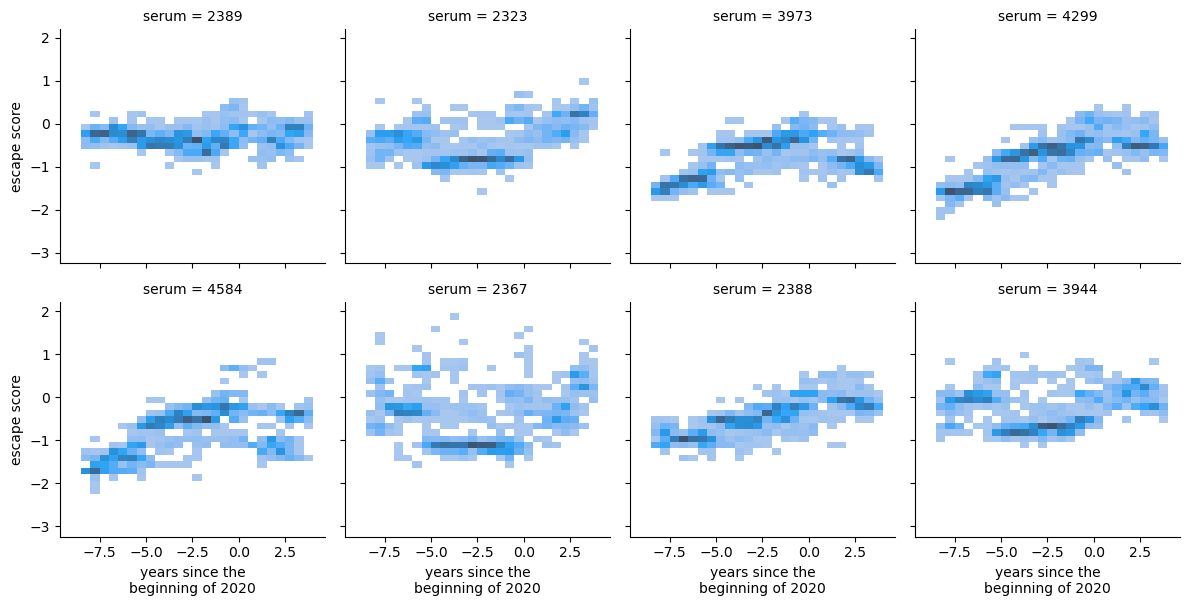

teenagers


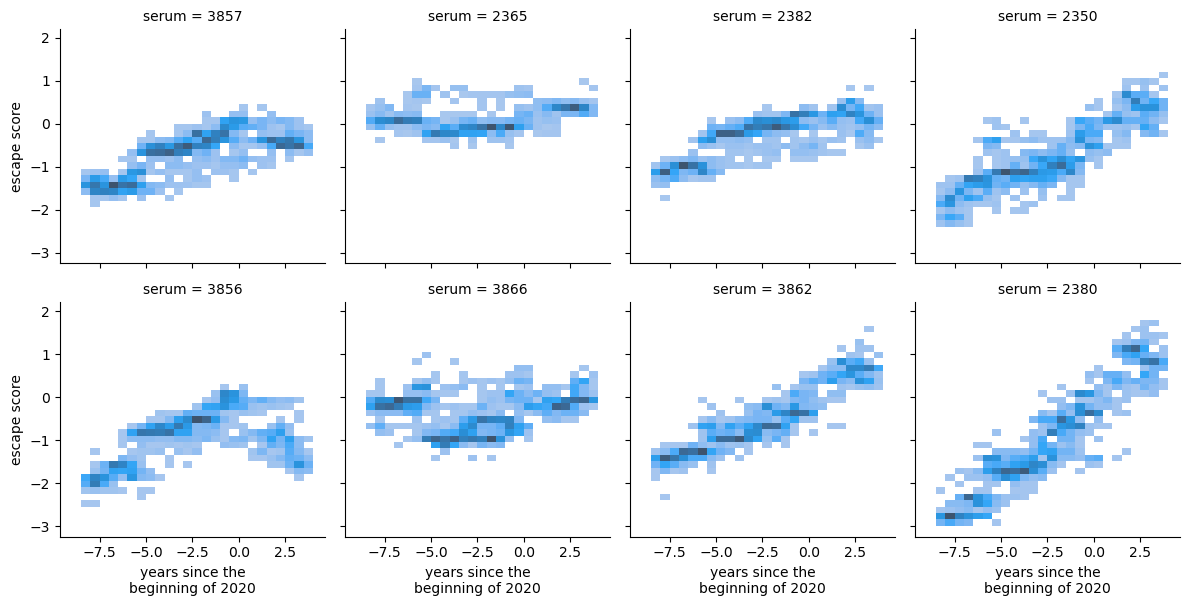

adults


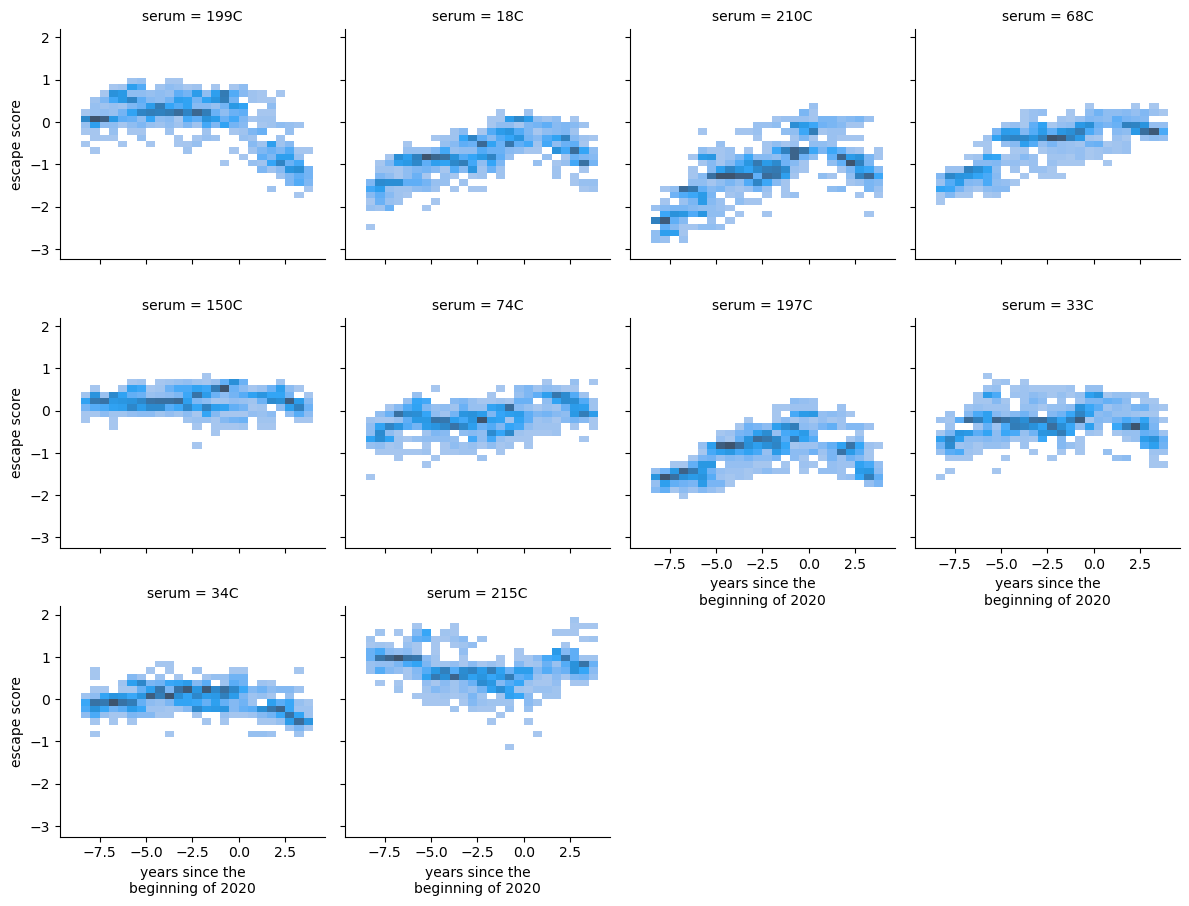

In [16]:
cohorts = ['infant', 'children', 'teenagers', 'adults']
for cohort in cohorts:
    print(cohort)
    data = escape_df[escape_df['cohort'] == cohort]
    binsx = np.arange(-9, 4.5, 0.5)
    binsy = np.arange(-3, 2, 0.15)
    g = sns.FacetGrid(data, col="serum", col_wrap=4)
    g.map(
        sns.histplot, "time", "escape_score",
        bins=(binsx, binsy)
    )
    g.set(ylabel='escape score', xlabel='years since the\nbeginning of 2020')
    plt.show()

To dos
* custom color scale that is standard between all runs